## Numerical Optimization
## Assignment 2
### Leon Kalderon
#### Case: Image Deblurring

$\textbf{Basic source}:$ http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/ImageDeblurring_2006.pdf

I appreciate the book of the professor Nicholas J.Higham since after reading it I understood both the theoretical and the technical part of the excercise.

Pages of the book(not the pdf) that refer to the spesific excercise:
<br>
-Matrix Computations with Kronecker Products , p. 49-51
<br>
-Implementation of Filtering Methods(Truncated and Titkhonov reconstruction), p. 74-77
<br>
-Regulation Errors and Pertubation Errors(Not essential for the implemention but the most important theoretical part in order to understand why we need filtering methods)   p. 77-79


$\textbf{General:}$
Since the whole theoretical part is explained perfectly in the 5 pages of the book mentioned above we will try to avoid copy-paste and we will just refer the basic equations.

$\textbf{prerequisites:}$ The reader should be familiar with SVD decomposition and he/she must have read and unserstand the .pdf with the excersice that it is attached in the folder.

### Read-Parse the file and split it into the 3 matricies

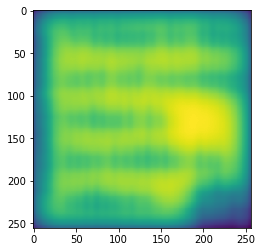

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#Read the data and transform them to 256x256 matricies
fname = 'data'
with open(fname) as f:
    content = f.readlines()
    
vec = []
for i in range(0,len(content)):
    ar = content[i][:-2].split(' ')
    ar = [float(i) for i in ar]
    vec.extend(ar)
    


A = np.array(vec[:65536])
A = A.reshape(256,256)

B = np.array(vec[65536:65536*2])
B = B.reshape(256,256)

G = np.array(vec[65536*2:])
G = G.reshape(256,256)
plt.imshow(G)
plt.show()

### Introduction

The most important kronecker product equation that we will use in order to reconstruct the image is:
(https://en.wikipedia.org/wiki/Kronecker_product, Matrix Equations or book page 50)
<br>
g = Kf + η where K = A $\bigotimes$ B
<br>
We can rewrite the above equation as:
<br>
G = BF$A^T$
<br>
That way we avoid to calculate K as a kronecker product because it would be very expensive computationally because its dimensions would be $65536x65536$ instead of $256x256$ that is A and B 
<br>
Hence, the equation is:
<br>
F = $B^{-1}$ G $A^{-T}$ <=>
<br>
F =$V_B$$Σ_B^{-1}$$U_B^T$G$U_A^T$$Σ_A^{-1}$$V_A^T$

In [2]:
#SVD decomposition for A and B
uA, sA, vtA = np.linalg.svd(A)
uB, sB, vtB = np.linalg.svd(B)

vA, vB = vtA.transpose(), vtB.transpose()

We notice that if $\hat{G} = U_B^TGU_A^T$
<br>
and S = vec(diag($Σ_B\bigotimes  Σ_Α$)), but since we know that $Σ_Α$ and $Σ_B$ are diagonal matricies we can compute S efficiently as diag($Σ_B$)*diag($Σ_B)^T$.
<br>
As a result, S will be a full matrix of rank 1.

So, $Σ_B^{-1}$$\hat{G}$$Σ_A^{-1}$ = $\hat{G}$ / S (element wise division)

In [3]:
#Calculate S and G_hat
S = np.outer(sB, sA.transpose())
G_hat = np.dot(np.dot(uB.transpose(), G), uA)

### Naive reconstruction
Now we have everything we need to calculate F (the 'reconstructed image')

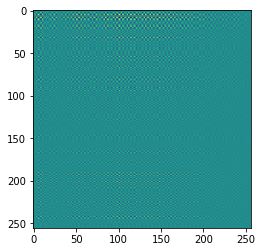

In [4]:
Funfiltered = np.matmul(np.matmul(vB, np.divide(G_hat,S)), vtA)
plt.imshow(Funfiltered)
plt.show()

We observe that this does not really work.
<br>
There is a 'new' error that has been introduced to our image because the inverted noise
term contaminates the reconstructed image. For a blurring matrix, all the
singular values decay gradually to zero and the condition number cond(A) = $σ_1$\ $σ_n$ is very
large. Since some singular values are very close to zero,the equation is very sensitive to perturbation and rounding errors.

In order to solve that problem, we apply a filter(Φ) in S and we use the new S (Sfiltered) in order to find F.

$\textbf{Truncated SVD:}$
<br>
We leave out the high-frequency components(the eigenvectors that their corresponding singular values are very close to zero), since they are dominated by error. The filter matrix Φ will have 1's and 0's. (pages:9-11, 77-79)

$\textbf{Titkhonov Regularization:}$
<br>
$φ_i$ = $σ_i^2$ / $σ_i^2$ + $λ^2$   (pages 74-79, 90)
<br>
In that way we indroduce a new regularize parameter λ to the denominator so we avoid pertubation errors when we have $σ_i$s very close to zero.



### Implementation of Truncated SVD

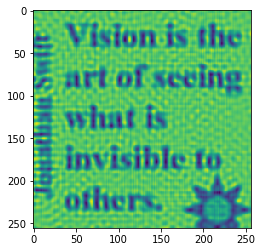

In [6]:
#First we create a filter that has zero below a threshold and ones above threshold
#threshold (user defined)
threshold = 0.0004
#We create the filter matrix by applying a function to every element of S
filt = np.zeros((256,256))
filt = np.vectorize(lambda x: 1 if x >= threshold else 0)(S)

#Sfilter (as has been mentioned above)
Sfilter = np.zeros((256,256))
Sfilter = np.divide(filt,S)

Xfiltered = np.dot(np.dot(vB, np.multiply(G_hat, Sfilter)), vtA)
plt.imshow(Xfiltered)
plt.show()

### Tikhonov SVD

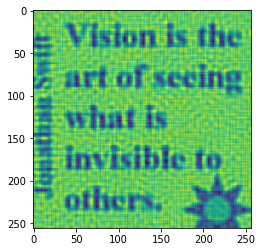

In [8]:
#Regularization parameter (user defined)
l = 0.0004

#Create the filter matrix by transforming all the values of S to s^2/(s^2 + l^2) as have been mentioned above
filt = np.zeros((256,256))
filt = np.vectorize(lambda s: pow(s,2)/(pow(s,2) + pow(l,2)))(S)

Sfilter = np.zeros((256,256))
Sfilter = np.divide(filt,S)

Xfiltered = np.dot(np.dot(vB, np.multiply(G_hat, Sfilter)), vtA)
plt.imshow(Xfiltered)
plt.show()

In order to better understand the mechanisms and regularizing properties of the spectral
filtering methods, we now take a closer look at the errors in the regularized solution x.
We observed that we can write $x_{filt}$ for both the TSVD solution and the Tikhonov
solution in terms of the SVD. Equipped with this formulation, we can now easily separate
the two different types of errors in a regularized solution, computed by means of spectral
filtering. Specifically, we have:

$x_{filt}$ = VΦ$Σ^{-1}$$U^T$b
            <br>
           = VΦ$Σ^{-1}$$U^T$$b_{exact}$ + VΦ$Σ^{-1}$$U^T$$b_{e}$
           <br>
           =VΦ$Σ^{-1}$$U^T$A$x_{exact}$ + VΦ$Σ^{-1}$$U^T$$b_{e}$
           <br>
           =VΦ$V^T$$x_{exact}$ + VΦ$Σ^{-1}$$U^T$$b_{e}$
           <br>
           and therefore the error in $x_{filt}$ is given by
           <br>
           $x_{exact}$-$x_{filt}$ = ($I_N$ - VΦ$V^T$)$x_{exact}$ - VΦ$Σ^{-1}$$U^T$$b_{e}$
           
    

We see that the error consists of two contributions with different origins.
<br>
-  Regularization Error.
<br>
The first component ($I_N$ - VΦ$V^T$)$x_{exact}$ is the regularization
error which is caused by using a regularized inverse matrix VΦ$Σ^{-1}$$U^T$(instead of
the inverse $A^{-1}$ = V$Σ^{-1}$$U^T$) in order to obtain the filtering. The matrix VΦ$V^T$
describes the mapping between the exact solution and the filtered solution $X_{filt}$. If
Φ = $I_N$, then the regularization error is zero, since V$V^T$ = $I_N$. The closer Φ is to
the identity, the smaller the regularization error.
<br>
-   Perturbation Error.
<br>
The second component VΦ$Σ^{-1}$$U^T$$b_{e}$ is the perturbation error
which consists of the inverted and filtered noise. If Φ = 0, then the perturbation error
is zero. When most of the filter factors are small (or zero), then the inverted noise is
heavily damped (the perturbation error is small).

Changes in the regularization parameter change Φ and the two kinds of errors. When
too many filter factors $φ_i$ are close to one, then the regularization error is small, but the perturbation
error is large because inverted noise enters the solution—we say that the solution is
undersmoothed. On the other hand, when too few filter factors are close to one, then the regularization
error is large while the perturbation error is small—the solution is oversmoothed.
A proper choice of the regularization parameter balances the two types of errors.
<br>
In our excericise, we tried to find the optimal parameters by trial and error. However, in the book(pages 80-83) the author explains how we can use cross-validation to find the optimal parameter that minimizes tha total error.  